[View in Colaboratory](https://colab.research.google.com/github/kempy/tf-scratch/blob/master/Update_ROI_in_an_Image_in_TensorFlow.ipynb)

## Edit image as tensorflow tensor python

https://stackoverflow.com/questions/51698848/edit-image-as-tensorflow-tensor-python

My goal is to perturb a ROI of this image by doing mathematical operations on the pixels, however, the issue is that the math must be done as a tensorflow tensor because the mathematical operation to be done is to multiply the tensor by it's scaled gradient (which is also a tensor of size (row_pixels, column_pixels, 3))

So here's the process I imagine:

 1. Read in image as numpy array RGB size: (1, 150, 150, 3) (1 is batch
    size) 

    `w, h = img.shape`

    `ret = np.empty((w, h, 3), dtype=np.uint8)`

    `ret[:, :, 0] = ret[:, :, 1] = ret[:, :, 2] = img`

 2. Make pixel values between 0 and 1

    `img = (faces1 - min_pixel) / (max_pixel - min_pixel)`

 3. `for i in range(steps):` 

 (a) extract ROI of image **this is the part I don't understand how to do** 

 (b) calculate gradient of smaller img ROI tensor's loss

    loss = utils_tf.model_loss(y, preds, mean=False)
    grad, = tf.gradients(loss, x)

 (c) multiply img ROI tensor by gradient of loss

    scaled_grad = eps * normalized_grad
    adv_img = img + scaled_grad

 (d) place this newly perturbed ROI tensor back into the same positions it was in the original tensor **this is the other part I don't understand how to do** 

This will result in an image where only some of the pixel values have been perturbed and the rest remain the same

In [0]:
# Imports
import cv2

import matplotlib.pyplot as plt
from IPython.display import Image
from PIL import Image as pil_image

import urllib, cStringIO

import numpy as np
import tensorflow as tf

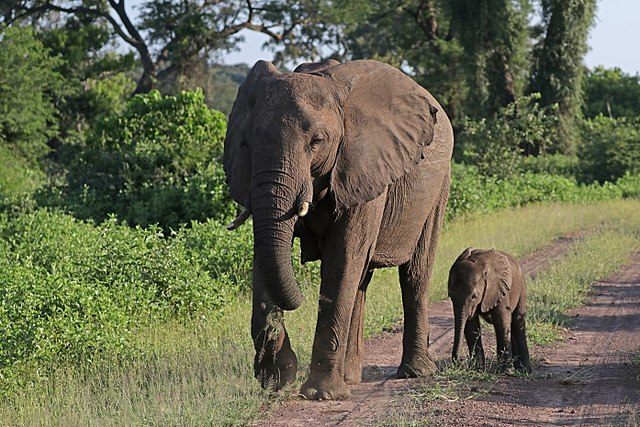

In [2]:
IMAGE_URL = 'https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/African_bush_elephants_%28Loxodonta_africana%29_female_with_six-week-old_baby.jpg/640px-African_bush_elephants_%28Loxodonta_africana%29_female_with_six-week-old_baby.jpg'

# Download the image and display the image
IMAGE_BYTES = urllib.urlopen(IMAGE_URL).read()
Image(IMAGE_BYTES)

In [0]:
# Helper functions

def show_image(img):
  plt.imshow(img.astype('float32'))
  plt.grid(False)
  plt.axis('off')
  plt.show()

Image shape:  (427, 640, 3)
Region of interest:  ((440, 240), (535, 380))


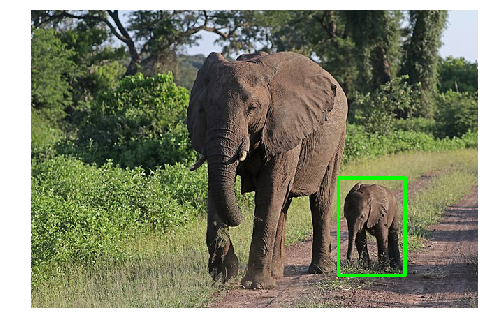

In [4]:
# Load the image in a numpy compatible format
image = pil_image.open(cStringIO.StringIO(IMAGE_BYTES))
np_image = np.asarray(image) / 255.
print 'Image shape: ', np_image.shape

# Pick a region of interest - the baby elephant
ROI = ((440, 240), (535, 380))
print 'Region of interest: ', ROI

np_image_with_roi = np_image.copy()
# Display the image with the bounding box
cv2.rectangle(np_image_with_roi, ROI[0], ROI[1], (0., 1., 0.), 3, 3)
show_image(np_image_with_roi)

(427, 640, 3)
[[440 240]
 [535 380]]
(427, 640, 3)
Orginal image fed in:


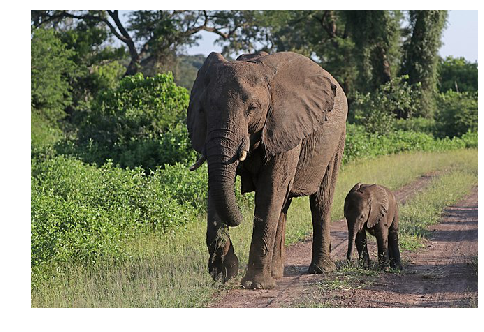

ROI extracted image:


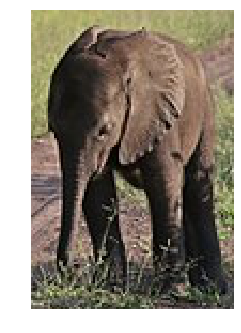

ROI mask:


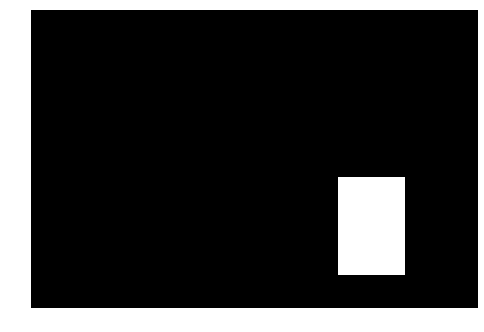

New image:


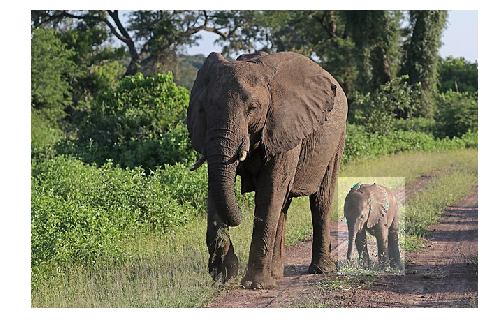

In [5]:
tf.reset_default_graph()

with tf.Graph().as_default():
  image_in = tf.placeholder(tf.float32, shape=np_image.shape)
  roi = tf.placeholder(tf.int32, shape=[2, 2])
  
  
  # Variables to help keep the corners of the ROI straight.
  top_left_x, top_left_y, top_left_z = roi[0][1], roi[0][0], 0
  bottom_right_x, bottom_right_y, bottom_right_z = roi[1][1], roi[1][0], 3
  roi_len_x, roi_len_y, roi_len_z = (
      bottom_right_x - top_left_x,
      bottom_right_y - top_left_y, 
      bottom_right_z - top_left_z)
  
  # Get the ROI slice from the image
  roi_slice = tf.slice(
    image_in,
    [top_left_x, top_left_y, top_left_z],
    [roi_len_x, roi_len_y, bottom_right_z]
  )
  
  # Get a boolean mask of the ROI
  roi_mask = tf.ones_like(roi_slice)
  mask_canvas = tf.image.pad_to_bounding_box(
    [roi_mask],
    top_left_x,
    top_left_y,
    np_image.shape[0],
    np_image.shape[1]
  )
  bool_mask = tf.cast(mask_canvas, tf.bool)
  
  # Make fake gradients that we can add to the image - replace with your real gradients.
  fake_gradients = tf.ones_like(image_in) * 0.2
  # Mask the gradients, gradient where the ROI is, 0 otherwise.
  masked_gradients = tf.where(bool_mask[0], fake_gradients, mask_canvas[0])
  
  # Make an editable copy of the image
  editable_image = tf.get_variable(
      name='editable_image', shape=image_in.shape, dtype=tf.float32)
  init_op = tf.assign(editable_image, image_in)
  
  # Make sure we don't update the image before we've set its initial value.
  with tf.control_dependencies([init_op]):
    update_roi_op = tf.assign_add(editable_image, masked_gradients)

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    image_out, roi_out, roi_slice_out, editable_image_out, mask_canvas_out, update_roi_out = sess.run(
        [image_in, roi, roi_slice, editable_image, mask_canvas, update_roi_op],
        feed_dict={
            image_in: np_image,
            roi: ROI
        })
    print image_out.shape
    print roi_out
    print image_out.shape
    print 'Orginal image fed in:'
    show_image(image_out)
    print 'ROI extracted image:'
    show_image(roi_slice_out)
    print 'ROI mask:'
    show_image(mask_canvas_out[0])
    print 'New image:'
    show_image(update_roi_out)